In [1]:
# libraries used
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import sklearn.metrics as metric
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import gradio as gr
import numpy as np
from tensorflow.keras.preprocessing import image

In [2]:
import os
print(os.getcwd())

C:\Users\nicyj\becode\Challenge_Mole


In [3]:
def metadata_read(metadata_file):
    '''Reading the metadata file and building label column with values malign and benign'''
    metadata = pd.read_csv(metadata_file)
    metadata = metadata.dropna(subset=['age'])
    list_of_mal = ['akiec','bcc', 'mel']
    metadata['label'] = np.where(metadata['dx'].isin(list_of_mal),'malign', None)
    metadata = metadata.replace({'label': {None: 'benign'}})
    metadata["image_id"] = metadata["image_id"].apply(lambda x: x + ".jpg")
    return(metadata)

In [4]:
def folder_label(metadata, malignfolder, benignfolder):
    '''Function to read the images and split it into folders according to their label from metadata. 
    It also transforms images of the minority class - malign'''
    # malign images
    malign_images = metadata[metadata['label'] == 'malign']['image_id'].to_list()
    for filename in malign_images:
        image = cv2.imread(os.path.join(folder, filename))
        cv2.imwrite(os.path.join(malignfolder,filename), image) # original image
        flip_image = cv2.flip(image, flipCode=cv2.ROTATE_180)
        flip_filename = 'flip'+filename
        cv2.imwrite(os.path.join(malignfolder, flip_filename), flip_image) # flipped image
        rotate_image = cv2.flip(image, flipCode=cv2.ROTATE_90_CLOCKWISE)
        rotate_filename = 'rotate'+filename
        cv2.imwrite(os.path.join(malignfolder, rotate_filename), rotate_image) # rotated image
    
    # benign images
    benign_images = metadata[metadata['label'] == 'benign']['image_id'].to_list()
    for filename in benign_images:
        image = cv2.imread(os.path.join(folder, filename))
        cv2.imwrite(os.path.join(benignfolder,filename), image)    

In [5]:
 def build_cnnmodel():
        '''Creating a CNN model'''
        model = Sequential()
        
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
        model.add(MaxPooling2D((2, 2)))

        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))

        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))

        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.5))

        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dense(2, activation = 'sigmoid'))
        
        #Compile the model
        model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
        
        print(model.summary())
        return(model)

In [6]:
# Reading csv file
metadata_file = "Data/archive/HAM10000_metadata.csv"
metadata = metadata_read(metadata_file)

In [7]:
# Splitting images into folders and minority class image transformations
folder = "Data/archive/HAM10000_images_part_1"
malignfolder = folder+'/malign'
benignfolder = folder+'/benign'
folder_label(metadata, malignfolder, benignfolder)

In [8]:
# Image Data Generator
src_path_train = "Data/archive/Images/train/"
src_path_test = "Data/archive/Images/test/"

train_datagen = ImageDataGenerator( 
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)

In [9]:
# Splitting the train, validation and test sets
batch_size = 8
train_generator = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(256,256),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)
valid_generator = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(256,256),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='validation',
    shuffle=True,
    seed=42
)
test_generator = test_datagen.flow_from_directory(
    directory=src_path_test,
    target_size=(256,256),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

Found 11090 images belonging to 2 classes.
Found 2772 images belonging to 2 classes.
Found 48 images belonging to 2 classes.


In [10]:
model = build_cnnmodel()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       1

In [11]:
# Fit the model using the generator

class_weights = {0:0.4,1:1}
history = model.fit(train_generator, 
                    steps_per_epoch=2000/32,
                    epochs=15, 
                    class_weight = class_weights,
                    validation_data=valid_generator,
                    validation_steps=2000/32)

Epoch 1/15
63/62 [==============================] - 29s 458ms/step - loss: 0.4329 - accuracy: 0.4683 - val_loss: 0.8512 - val_accuracy: 0.4008
Epoch 2/15
63/62 [==============================] - 32s 503ms/step - loss: 0.4116 - accuracy: 0.4484 - val_loss: 0.7618 - val_accuracy: 0.4127
Epoch 3/15
63/62 [==============================] - 32s 505ms/step - loss: 0.4104 - accuracy: 0.5437 - val_loss: 0.7014 - val_accuracy: 0.5952
Epoch 4/15
63/62 [==============================] - 31s 486ms/step - loss: 0.3805 - accuracy: 0.5893 - val_loss: 0.5929 - val_accuracy: 0.6468
Epoch 5/15
63/62 [==============================] - 31s 491ms/step - loss: 0.3869 - accuracy: 0.5615 - val_loss: 0.7602 - val_accuracy: 0.4107
Epoch 6/15
63/62 [==============================] - 30s 479ms/step - loss: 0.4093 - accuracy: 0.4127 - val_loss: 0.7357 - val_accuracy: 0.4226
Epoch 7/15
63/62 [==============================] - 30s 477ms/step - loss: 0.3969 - accuracy: 0.5040 - val_loss: 0.7301 - val_accuracy: 0.4861

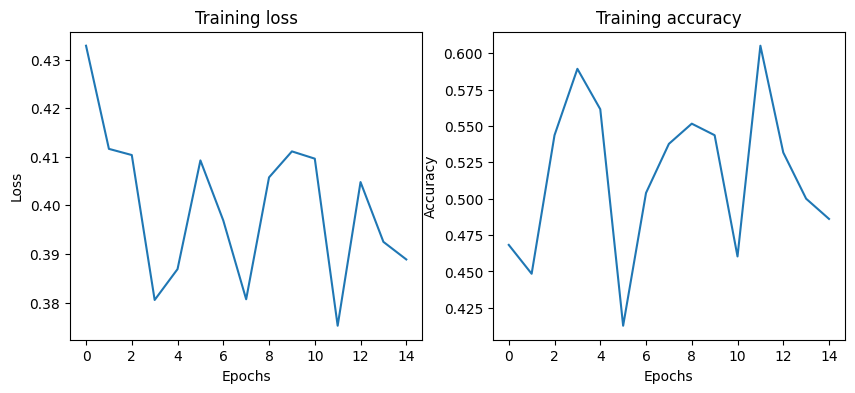

In [12]:
# Plotting the training loss and accuracy

loss = history.history['loss']
accuracy = history.history['accuracy']
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(10,4))
axs[0].plot(range(len(loss)), loss)
axs[0].set(xlabel="Epochs", ylabel="Loss", title="Training loss")
axs[1].plot(range(len(accuracy)), accuracy)
axs[1].set(xlabel="Epochs", ylabel="Accuracy", title="Training accuracy")
plt.show()

In [13]:
# Predicting with the model

test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes)

[0 0 0 0 0 1 1 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1]


In [15]:
# Calculating the precision, recall and f1score

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
report = metric.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)    

              precision    recall  f1-score   support

      benign       0.94      0.62      0.75        24
      malign       0.72      0.96      0.82        24

    accuracy                           0.79        48
   macro avg       0.83      0.79      0.79        48
weighted avg       0.83      0.79      0.79        48



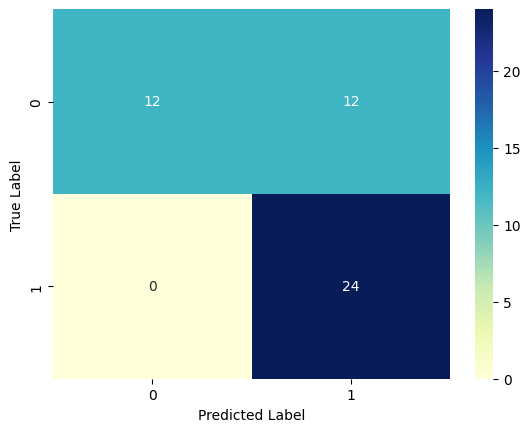

In [21]:
# Calculating the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [16]:
def classify_image(inp):

  x = image.img_to_array(inp)
  x = np.expand_dims(x, axis=0)  
  datagen = ImageDataGenerator(rescale=1./255)
  x = datagen.standardize(x)  
  preds = model.predict(x)
  pred_label = np.argmax(preds, axis=1)  
  print(pred_label)
  if pred_label == 0:
    text = 'The mole seems to be benign'
  if pred_label == 1:
    text = 'The mole seems to be cancerous. It is advised to visit a doctor for a follow-up'
  return text

In [17]:
description = '''Moles can be linked to skin cancer. This is especially true if you have a family history of skin cancer linked to moles. In addition to limiting your exposure to sunlight and using sunscreens, examining yourself for moles can help with early detection of melanoma (the deadliest type of skin cancer) and treatment.'''

In [18]:
gr.Interface(fn=classify_image, 
                 inputs=gr.Image(shape=(256, 256)),
             outputs="text",
             live = True,
            title = 'SkinCare',
            description = description).launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


[0]


Traceback (most recent call last):
  File "C:\Users\nicyj\miniconda3\envs\tf_mole\lib\site-packages\gradio\routes.py", line 343, in run_predict
    event_id=event_id,
  File "C:\Users\nicyj\miniconda3\envs\tf_mole\lib\site-packages\gradio\blocks.py", line 1016, in process_api
    fn_index, inputs, iterator, request, event_id
  File "C:\Users\nicyj\miniconda3\envs\tf_mole\lib\site-packages\gradio\blocks.py", line 834, in call_function
    fn, *processed_input, limiter=self.limiter
  File "C:\Users\nicyj\miniconda3\envs\tf_mole\lib\site-packages\anyio\to_thread.py", line 29, in run_sync
    limiter=limiter)
  File "C:\Users\nicyj\miniconda3\envs\tf_mole\lib\site-packages\anyio\_backends\_asyncio.py", line 818, in run_sync_in_worker_thread
    return await future
  File "C:\Users\nicyj\miniconda3\envs\tf_mole\lib\site-packages\anyio\_backends\_asyncio.py", line 754, in run
    result = context.run(func, *args)
  File "C:\Users\nicyj\AppData\Local\Temp\ipykernel_24884\809273695.py", line 3

[1]
